# Time-Independent Schrödinger Equation for a Particle in a Box:
\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} = E\psi
\end{equation}

# Quantization of Energy Levels:

\begin{equation}
E_n = \frac{n^2 \pi^2 \hbar^2}{2mL^2}
\end{equation}

# Boundary Conditions:
At x=0,
\begin{equation}
\psi(0) = 0 = C\sin(0) + D\cos(0) = D
\end{equation}
Thus,
D=0.

At
x=L,

\begin{equation}
\psi(L) = 0 = C\sin(kL),
\end{equation}

we consider the following initial conditions of the system:

\begin{equation}
\psi(0) = \psi(L) = 0
\end{equation}

# Loss Function for the PINN:

\begin{equation}
\text{loss} = \text{mean}\left(\left(-\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} - E\psi\right)^2\right)
\end{equation}

# Exact Solution for the Lowest Energy State (n=1):

\begin{equation}
\psi_{\text{exact}}(x) = \sqrt{\frac{2}{L}} \sin\left(\frac{\pi x}{L}\right)
\end{equation}

#I will solve n=1 i first part:
\begin{equation}
k = \frac{n\pi}{L} \qquad n=1,2,3,\ldots
\end{equation}


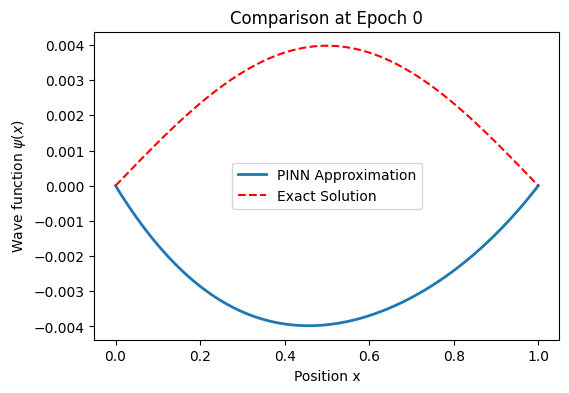

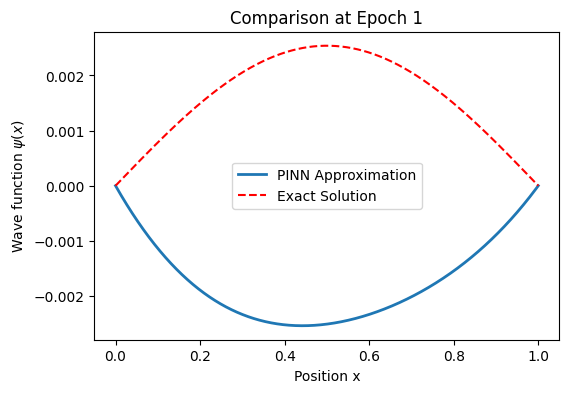

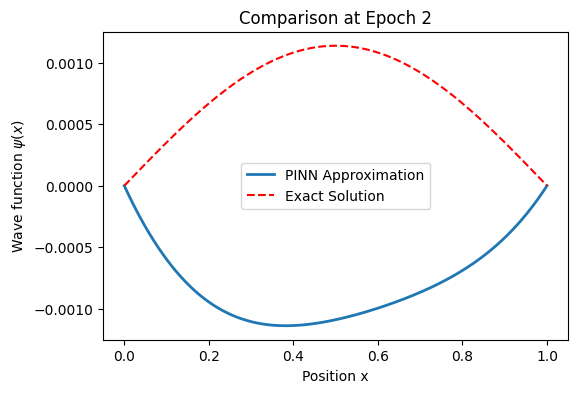

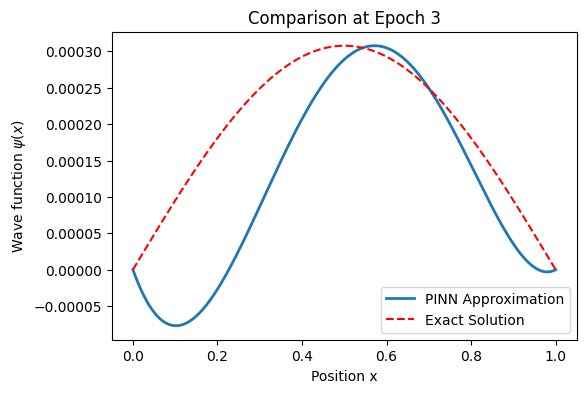

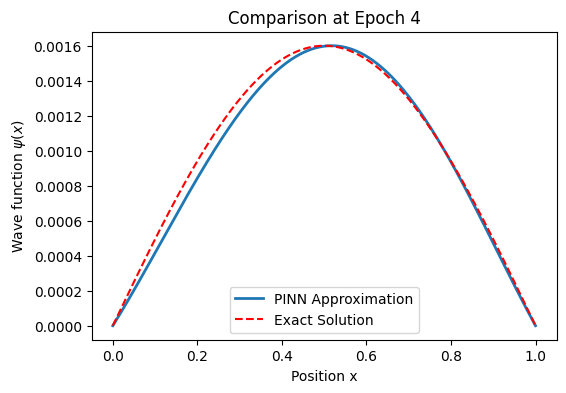

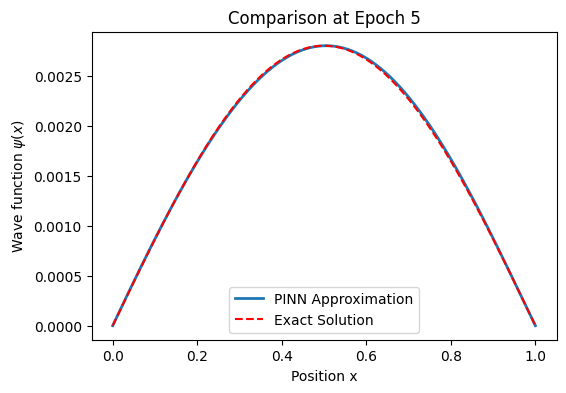

In [51]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random  # Ensure random is imported

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# If you are using CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Exact solution for n=1
def psi_exact_n1(x, L):  # Added L as a parameter to make it clear
    return np.sqrt(2/L) * np.sin(np.pi * x.detach().numpy() / L)  # Use detach().numpy() for compatibility

class SchrodingerPINN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers, L):
        super(SchrodingerPINN, self).__init__()
        self.L = L  # Domain length added as an attribute
        activation = nn.Tanh
        layers = [nn.Linear(n_input, n_hidden), activation()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_hidden, n_hidden), activation()]
        layers += [nn.Linear(n_hidden, n_output)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Multiply the model output by x(L-x) to enforce the output to be 0 at the boundaries
        return x * (self.L - x) * self.model(x)

L = 1.0  # Domain length
# Initialize the PINN model, now including L as an argument
pinn = SchrodingerPINN(n_input=1, n_output=1, n_hidden=50, n_layers=5, L=L)

# Define the optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0001)

def schrodinger_loss(x, model, L, n):
    psi = model(x)
    psi_grad = torch.autograd.grad(psi, x, torch.ones_like(psi), create_graph=True, retain_graph=True)[0]
    psi_grad2 = torch.autograd.grad(psi_grad, x, torch.ones_like(psi_grad), create_graph=True)[0]
    hbar = 1.0  # Planck's constant over 2pi
    m = 1.0     # Particle mass
    E = n**2 * np.pi**2 * hbar**2 / (2 * m * L**2)  # Energy for quantum number n
    loss_schrodinger = torch.mean(((-hbar**2 / (2 * m)) * psi_grad2 - E * psi) ** 2)
    # The boundary loss is implicitly handled by the model's architecture now
    return loss_schrodinger

x = torch.linspace(0, L, 1000).view(-1, 1).requires_grad_(True)
n = 1  # Quantum number for the targeted solution

epochs = 6
plot_every = 1

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = schrodinger_loss(x, pinn, L, n)  # Include L and n as parameters
    loss.backward()
    optimizer.step()

    if epoch % plot_every == 0 or epoch == epochs - 1:
        with torch.no_grad():
            psi_pred = pinn(x)
            x_numpy = x.detach().numpy()
            psi_exact_unnormalized = psi_exact_n1(x, L)  # Pass L as argument

            normalization_factor = torch.max(torch.abs(psi_pred)) / np.max(np.abs(psi_exact_unnormalized))
            psi_exact_normalized = psi_exact_unnormalized * normalization_factor.item()  # Correct normalization

            plt.figure(figsize=(6, 4))
            plt.plot(x_numpy, psi_pred.detach().numpy(), label='PINN Approximation', linewidth=2)
            plt.plot(x_numpy, psi_exact_normalized, label='Exact Solution', linestyle='--', color='r')
            plt.xlabel('Position x')
            plt.ylabel('Wave function $\psi(x)$')
            plt.title(f'Comparison at Epoch {epoch}')
            plt.legend()
            plt.show()


# Exact Solution for the Wave Function (n=2):

\begin{equation}
\psi_{\text{exact}, n=2}(x) = \sqrt{\frac{2}{L}} \sin\left(\frac{2 \pi x}{L}\right)
\end{equation}

# Boundary Conditions:
\begin{equation}
\psi(0) = \psi(L) = 0
\end{equation}

# Physics-Informed Loss Function:

\begin{equation}
\text{loss} = \text{mean}\left(\left(-\frac{\hbar^2}{2m} \frac{d^2\psi_{\text{pred}}}{dx^2} - E_n \psi_{\text{pred}}\right)^2\right) + \left(\psi_{\text{pred}}(0)^2 + \psi_{\text{pred}}(L)^2\right)
\end{equation}

#I will solve n=2 in this second part:

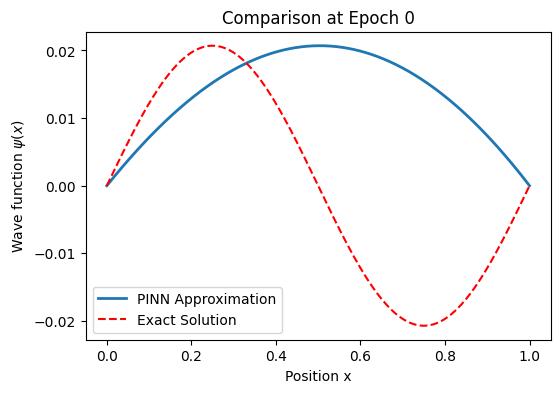

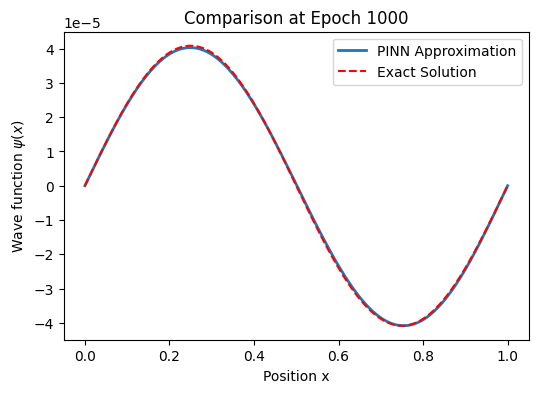

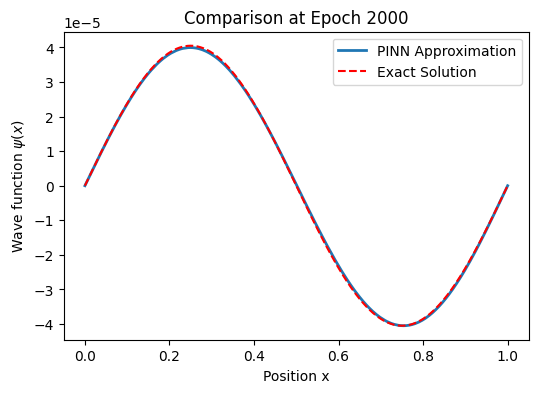

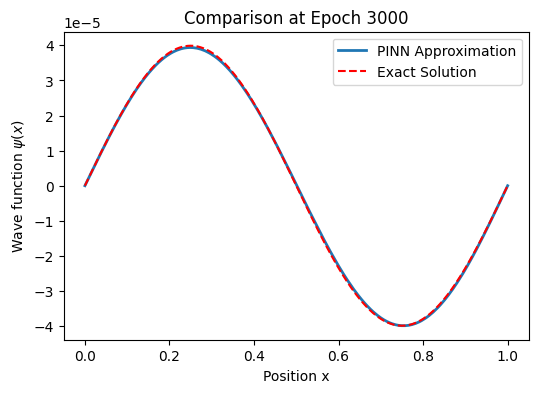

In [36]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random  # Import the random module

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)  # This now works because the random module is imported
# If you are using CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Exact solution for n=2
def psi_exact_n2(x, L):
    return np.sqrt(2/L) * np.sin(2 * np.pi * x.detach().numpy() / L)

class SchrodingerPINN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers, L):
        super(SchrodingerPINN, self).__init__()
        self.L = L  # Store the domain length
        activation = nn.Tanh
        layers = [nn.Linear(n_input, n_hidden), activation()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_hidden, n_hidden), activation()]
        layers += [nn.Linear(n_hidden, n_output)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Ensuring the output is zero at the boundaries by construction
        return x * (self.L - x) * self.model(x)

L = 1.0  # Domain length
pinn = SchrodingerPINN(n_input=1, n_output=1, n_hidden=135, n_layers=5, L=L)

# Define the optimizer with a potentially smaller learning rate
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0003)

# Implement learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

def schrodinger_loss(x, model, L, n):
    psi = model(x)
    psi_grad = torch.autograd.grad(psi, x, torch.ones_like(psi), create_graph=True, retain_graph=True)[0]
    psi_grad2 = torch.autograd.grad(psi_grad, x, torch.ones_like(psi_grad), create_graph=True)[0]
    hbar = 1.0
    m = 1.0
    E = n**2 * np.pi**2 * hbar**2 / (2 * m * L**2)
    loss_schrodinger = torch.mean(((-hbar**2 / (2 * m)) * psi_grad2 - E * psi) ** 2)
    loss_boundary = psi[0]**2 + psi[-1]**2
    return loss_schrodinger + loss_boundary

n = 2    # Quantum number
x = torch.linspace(0, L, 1000).view(-1, 1).requires_grad_(True)

epochs = 3001  # Increased number of epochs
plot_every = 1000  # Adjusted plot frequency for longer training

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = schrodinger_loss(x, pinn, L, n)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Adjust learning rate

    if epoch % plot_every == 0 or epoch == epochs - 1:
        with torch.no_grad():
            psi_pred = pinn(x)
            x_numpy = x.detach().numpy()
            psi_exact_unnormalized = psi_exact_n2(x, L)

            normalization_factor = torch.max(torch.abs(psi_pred)) / np.max(np.abs(psi_exact_unnormalized))
            normalization_factor_numpy = normalization_factor.item()  # Changed from numpy() for scalar
            psi_exact_normalized = psi_exact_unnormalized * normalization_factor_numpy

        plt.figure(figsize=(6, 4))
        plt.plot(x_numpy, psi_pred.detach().numpy(), label='PINN Approximation', linewidth=2)
        plt.plot(x_numpy, psi_exact_normalized, label='Exact Solution', linestyle='--', color='r')
        plt.xlabel('Position x')
        plt.ylabel('Wave function $\psi(x)$')
        plt.title(f'Comparison at Epoch {epoch}')
        plt.legend()
        plt.show()
